## Exploring performance of BERT transformer with current dataset
Goal is just to see how good of a results BERT will give on the "raw" dataset using Google Colab.

### Dataset preparation
Minimal cleaning and preprocessing made on this dataset. Just to make it run.

In [1]:
from transformers import BertTokenizer
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_texts(texts, labels, max_lenght=512):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_lenght
    )
    return encodings, labels

df = pd.read_csv('/content/drive/MyDrive/data/sentio_dataset.csv')


category_map = {
    'Normal': 0,
    'Depression': 1,
    'Suicidal': 2,
    'Anxiety': 3,
    'Stress': 4,
    'Bipolar': 5,
    'Personality disorder': 6
}

# Minor cleaning and preprocessing
# - handling missing values
# - map categories to numerical labels
texts = df['statement'].fillna('').astype(str).tolist()
labels = df['status'].map(category_map).tolist()

encodings, labels = tokenize_texts(texts, labels)

Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Set up class for dataset

In [2]:
import torch
from torch.utils.data import Dataset

class SentioDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = SentioDataset(encodings, labels)

### Model setup

In [3]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=7,
    problem_type='single_label_classification'
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training configuration

In [4]:
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding='max_length',
    max_length=512
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding='max_length',
    max_length=512
)

train_dataset = SentioDataset(train_encodings, train_labels)
val_dataset = SentioDataset(val_encodings, val_labels)

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/sentio_results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    fp16=True,
    report_to='none',
    disable_tqdm=False,
    logging_first_step=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.351300,0.463941
2,0.356600,0.432604


TrainOutput(global_step=10610, training_loss=0.48768752715028085, metrics={'train_runtime': 1347.3029, 'train_samples_per_second': 62.991, 'train_steps_per_second': 7.875, 'total_flos': 2.23307114935296e+16, 'train_loss': 0.48768752715028085, 'epoch': 2.0})

### Evaluation

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)

print(classification_report(val_labels, preds))
print(confusion_matrix(val_labels, preds))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3270
           1       0.82      0.79      0.80      3081
           2       0.74      0.78      0.76      2131
           3       0.88      0.87      0.88       778
           4       0.75      0.75      0.75       534
           5       0.87      0.85      0.86       575
           6       0.67      0.71      0.69       240

    accuracy                           0.85     10609
   macro avg       0.81      0.82      0.81     10609
weighted avg       0.85      0.85      0.85     10609

[[3145   20   22    7   69    1    6]
 [  33 2427  564   11    9   27   10]
 [  37  434 1656    2    2    0    0]
 [  13   14    0  680   27   21   23]
 [  45   21    0   37  401   11   19]
 [   4   22    2   17   15  488   27]
 [   6   18    3   17   12   14  170]]


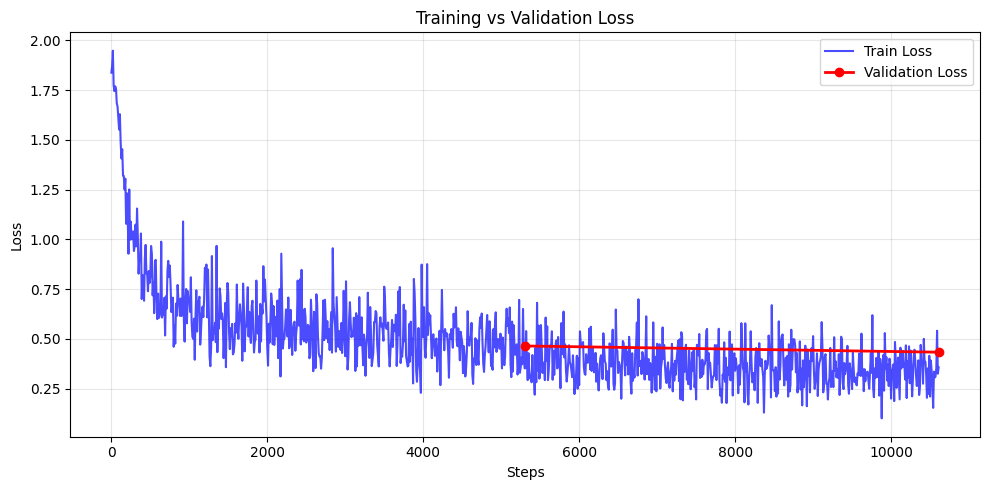

Final Train Loss: 0.3566
Final Validation Loss: 0.4326
Best Validation Loss: 0.4326


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

log_history = trainer.state.log_history

train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

train_loss = [log['loss'] for log in train_logs]
train_steps = [log['step'] for log in train_logs]

eval_loss = [log['eval_loss'] for log in eval_logs]
eval_epochs = [log['epoch'] for log in eval_logs]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_steps, train_loss, 'b-', label='Train Loss', alpha=0.7)
ax.plot([step for log in eval_logs for step in [log['step']]], eval_loss, 'r-', marker='o', label='Validation Loss', linewidth=2)
ax.set_xlabel('Steps')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Train Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {eval_loss[-1]:.4f}")
print(f"Best Validation Loss: {min(eval_loss):.4f}")